# Predict Discount Based on Age

In [1]:
from random import randrange, choice
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## Create Data

In [2]:
sample_size =10000
data_file = f'../data/discount_data_{sample_size}.xlsx'

business_list = ['bar', 'restaurant', 'hotel', 'pharmacy', 'spa', 'airline']


def calculate_discount(age, sex, business_type, is_resident):
    business_discounts = dict()
    business_discounts['restaurant'] = 0.2
    business_discounts['pharmacy'] = 0.2
    business_discounts['hotel'] = 0.25
    
    if sex == 'M' and age >= 64 and is_resident:
        return business_discounts.get(business_type, 0.0)
    elif sex == 'F' and age >= 57 and is_resident:
        return business_discounts.get(business_type, 0.0)
    else:
        return 0.0
    
def build_dataframe(samples):

    data = dict()
    data['sex'] = list()
    data['age'] = list()
    data['business_type'] = list()
    data['discount'] = list()
    data['is_resident'] = list()
    for i in range(samples):
        age = randrange(18, 95, 1)
        sex = choice(['M', 'F'])
        business_type = choice(business_list)
        is_resident =  choice([True, False])
        discount = calculate_discount(age, sex, business_type, is_resident)
        #print(f'{sex} age {age} for {business_type}')
        data['sex'].append(sex)
        data['age'].append(age)
        data['business_type'].append(business_type)
        data['discount'].append(discount)
        data['is_resident'].append(is_resident)

        df = pd.DataFrame.from_dict(data)
    return df
    


In [3]:
if os.path.exists(data_file):
    df = pd.read_excel(data_file)
    print(f'Loaded from {data_file}')
else:
    df = build_dataframe(sample_size)
    df.to_excel(data_file, index=False)
    print(f'Saved to {data_file}')

Loaded from ../data/discount_data_10000.xlsx


In [4]:
print(f'Shape: {df.shape}')
df.head()

Shape: (10000, 5)


,sex,age,business_type,discount,is_resident
0,F,78,bar,0.0,True
1,F,24,bar,0.0,False
2,F,45,bar,0.0,True
3,F,21,pharmacy,0.0,False
4,F,45,pharmacy,0.0,False


## Cleanup


### Separate dependent and independent variables

In [5]:
discounts = df['discount'].copy()
df.drop(columns=['discount',], inplace=True)

print(f'discount shape: {discounts.shape}')

df.head()

discount shape: (10000,)


,sex,age,business_type,is_resident
0,F,78,bar,True
1,F,24,bar,False
2,F,45,bar,True
3,F,21,pharmacy,False
4,F,45,pharmacy,False


### Hot One Encode

In [6]:
df = pd.get_dummies(df, columns=['sex', 'business_type'])


In [7]:


df['is_resident'].replace({False: 0, True: 1}, inplace=True)

### Scaling age

In [8]:
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


In [9]:
print(f'Shape: {df.shape}')
df.head()

Shape: (10000, 10)


,age,is_resident,sex_F,sex_M,business_type_airline,business_type_bar,business_type_hotel,business_type_pharmacy,business_type_restaurant,business_type_spa
0,0.789474,1,1,0,0,1,0,0,0,0
1,0.078947,0,1,0,0,1,0,0,0,0
2,0.355263,1,1,0,0,1,0,0,0,0
3,0.039474,0,1,0,0,0,0,1,0,0
4,0.355263,0,1,0,0,0,0,1,0,0


## Spliting data

In [10]:
X_train, X_rem, y_train, y_rem = train_test_split(df.values, discounts.values, 
                                                  train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


## Basic Neuronal Network


In [11]:
learning_rate = 0.01
input_layer = tf.keras.layers.Dense(units=1, input_shape=[df.shape[1]])
hidden_layer_0 = tf.keras.layers.Dense(units=512, activation='sigmoid')
hidden_layer_1 = tf.keras.layers.Dense(units=256, activation='sigmoid')
output_layer = tf.keras.layers.Dense(units=1)

In [12]:
model = tf.keras.models.Sequential()

model.add(input_layer)
model.add(hidden_layer_1)
model.add(output_layer)


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mean_squared_error',
    metrics=['accuracy']
)

In [14]:
batch_size=64
num_epochs=25
history = model.fit(df.values, discounts.values,
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/25
157/157 [==============================] - 1s 982us/step - loss: 0.1147 - accuracy: 0.8532
Epoch 2/25
157/157 [==============================] - 0s 860us/step - loss: 0.0048 - accuracy: 0.8926
Epoch 3/25
157/157 [==============================] - 0s 976us/step - loss: 0.0053 - accuracy: 0.8926
Epoch 4/25
157/157 [==============================] - 0s 911us/step - loss: 0.0052 - accuracy: 0.8926
Epoch 5/25
157/157 [==============================] - 0s 985us/step - loss: 0.0054 - accuracy: 0.8926
Epoch 6/25
157/157 [==============================] - 0s 925us/step - loss: 0.0062 - accuracy: 0.8926
Epoch 7/25
157/157 [==============================] - 0s 988us/step - loss: 0.0072 - accuracy: 0.8926
Epoch 8/25
157/157 [==============================] - 0s 1ms/step - loss: 0.0059 - accuracy: 0.8926
Epoch 9/25
157/157 [==============================] - 0s 904us/step - loss: 0.0076 - accuracy: 0.8926
Epoch 10/25
157/157 [==============================] - 0s 3ms/step - loss: 0.0067 - 

In [15]:
print(history.history)

{'loss': [0.11473803967237473, 0.004786906763911247, 0.005347029771655798, 0.005166511982679367, 0.0053580342791974545, 0.006185151636600494, 0.007222359534353018, 0.005906851030886173, 0.007601572200655937, 0.00669446773827076, 0.007047587540000677, 0.008371613919734955, 0.010788053274154663, 0.005896054673939943, 0.007745035458356142, 0.0037121193017810583, 0.003972241654992104, 0.006328803952783346, 0.005484063643962145, 0.002763159340247512, 0.00420628534629941, 0.0037811966612935066, 0.004591985139995813, 0.005121215712279081, 0.004961088299751282], 'accuracy': [0.8532000184059143, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925999999046326, 0.8925

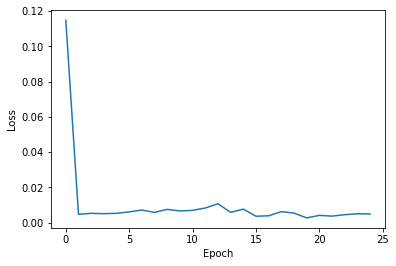

In [16]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.show()

In [17]:
df_values = df.values
disc_value = discounts.values

for i in range(500):
    if disc_value[i] > 0.0:
        print(i)
        break

36


In [18]:
print(df_values[36].reshape(1,10))
print(disc_value[36])

[[0.92105263 1.         1.         0.         0.         0.
  0.         1.         0.         0.        ]]
0.2


In [19]:
pred = model.predict(df_values[36].reshape(1,10))

print(f'Estimated discount {pred}')

Estimated discount [[0.34570786]]


In [20]:
pred = model.predict(df_values[0].reshape(1,10))

print(f'Estimated discount {pred}')

Estimated discount [[0.11819388]]
